In [2]:
import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
%matplotlib inline
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
#############################################
import warnings
warnings.filterwarnings("ignore")
#############################################
import os,sys
from copy import deepcopy as dcopy
import numpy as np
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
import pysm3
import pysm3.units as u
#############################################
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation//beam_analyzes/scripts')
import beam_modelling         as model
import handling_data          as hdata
import parameters_and_setting as parset
import plot_setting           as pset

In [3]:
output_info = {"pathdir_HI" :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI512',
               "pathdir_N"  :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/WN512',
               "realization": 2,
               "pathdir_FG" :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/FG512',
               "nameFG"     :'FG_I_512_980mhz1260mhz_30bins_full_L0.fits',
               "pathdir_PL" :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/PL512',
               "namePL"     :'PL_QU_512_980mhz1260mhz_30bins_full_2eQ_1eU_L0.fits',
               "apply_mask" : True,
               "pathdir_M"  :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/M256',
               "nameM"      :'mask_256_5degC2apod_20fgcut.fits',
               "apply_beam" : True, 
               "type_beam"  :'gaussian',
               "type_fwhm"  :'ripple',
               "if_fwhm_cte": None,
               "main_dish_diameter": 40,
               "lmax"       : None,
               "theta_range": None,
               'new_nside'  : 256,
               'output_dir' :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset_processed',
               'first_name' :'BINGO',
               'add_name' : None
              }

In [4]:
def get_realization_id_from_filename(filename_=None, new_format=False):
    if new_format:
        return filename_.split("_L")[1].split(".fits")[0]
    else:
        return filename_.split('-')[1].split('r')[1]
def get_all_realizations_id(filenames_=None, new_format=False):
    IDs = np.array([])
    for i,ifilename in enumerate(filenames_):
        _id_ =get_realization_id_from_filename(filename_=ifilename,  new_format=new_format)
        IDs = np.append(IDs,_id_)
    return np.unique(IDs)    

def get_filenames4realizations(filenames_=None,ids_=None, new_format=False): #ids_: all realization name index. Fex: ['0001', '0002', ..., '0100']
    for i,_id_ in enumerate(ids_):
        if not i:
            idic = {_id_:np.array([])}
        else:
            idic[_id_] = np.array([])
    for i,ifilename in enumerate(filenames_):
        _id_ = get_realization_id_from_filename(filename_=ifilename,  new_format=new_format)
        idic[_id_] = np.hstack((idic[_id_],ifilename))
    for _id_ in idic.keys():
        idic[_id_] = np.sort(idic[_id_])
    return idic

def building_cubemaps_from_realization(pathdir_=None, filenames_=None, healpix_readingformat=True):#this's for one id and not for all of them
    from copy import deepcopy as dcopy
    dirname_ = pathdir_.split("/")[-1]
    ginfo    = get_info_from_filename(dirname_= dirname_, filename_=filenames_[0])
    HImaps   = np.ones((ginfo['frequency']['nbands'],12*(ginfo['NSIDE'])**2))
    for i,ifilename in enumerate(filenames_):
        ifilename = os.path.join(pathdir_, ifilename)
        numname   = int(ifilename.split(".fits")[0].split('z')[1])-1 #names in z between 1-30, but cube between 0-29 numeration
        imap      = getmap(dirpath_=pathdir_, filename_=ifilename, healpix_readingformat=healpix_readingformat)
        HImaps[numname,:] = dcopy(imap)   
    return HImaps

In [5]:
#Loop1: realizations
#ifilename = np.sort(filenames)[11]
#ids_      = hdata.get_all_realizations_id(filenames, new_format=True)
def beam_observed_maps(output_info=None, ifilename=None):
    HImap     = hdata.getmap(dirpath_ =output_info['pathdir_HI'], 
                             filename_=ifilename, 
                             healpix_readingformat=False, hdu=1) 
    imap = dcopy(HImap) 
    for i, ifield in enumerate(['FG', 'PL']):
        if type(output_info['name{}'.format(ifield)])!=type(None):
            jmap = hdata.getmap(dirpath_ = output_info['pathdir_{}'.format(ifield)], 
                                filename_= output_info['name{}'.format(ifield)], 
                               healpix_readingformat=False, hdu=1)
            imap +=jmap 
            if not i:
                fields = {'{} maps'.format(ifield): jmap}
            else:
                fields['{} maps'.format(ifield)]=jmap
        else:
            if not i:
                fields = {'{} maps'.format(ifield): 0*imap}
            else:
                fields['{} maps'.format(ifield)]=0*imap       
    #Loop2: channels
    omap = np.zeros((imap.shape[0], hp.nside2npix(output_info['new_nside'])))
    bl   = np.zeros((imap.shape[0], int(output_info['lmax']+1)))
    for i, inu in enumerate(output_info['nu'][:-1]):
        output_info['fwhm'] = dcopy(model.fwhm_modelling(nu=inu, type_= output_info["type_fwhm"], D=output_info["main_dish_diameter"], in_degree=True))
        bl[i,:]             = model.bl_function(type_=output_info['type_beam'], fwhm=output_info['fwhm'] , lmax=output_info['lmax'], theta_=output_info['theta_range'], input_unit="degree")
        omap[i]             = dcopy(hp.ud_grade(imap[i], output_info['new_nside']))
    imap = dcopy(omap)
    del omap
    
    if output_info['apply_beam']:
        imap_mod = np.zeros_like(imap)
        for i,imap_ in enumerate(imap):
            alm_imap     = hp.map2alm(imap_,lmax=output_info['lmax'])
            alm_imap_mod = hp.almxfl(alm_imap, bl[i])
            imap_mod[i]  = hp.alm2map(alm_imap_mod,nside=output_info['new_nside'],lmax=output_info['lmax'], pol=False)
    else:
        imap_mod = np.zeros_like(imap)       
    #del HImap, jmap, alm_imap, alm_imap_mod, output_info['fwhm'], bl, output_info['theta_range'], output_info['nu'], output_info['l']
    return {"unconvolved map": imap,
            "convolved map"  : imap_mod,
            "HI maps": HImap,
            "FG maps": fields['FG maps'],           
            "PL maps": fields['PL maps'],}


def sky_observation(output_info=None, ifilename=None):
    beamed_map   = beam_observed_maps(output_info, ifilename)
    beamed_map['observed map']=dcopy(beamed_map['convolved map'])
    if type(output_info['pathdir_N'])!=type(None) and type(output_info['pathdir_N'])==np.str:
        id                   = ifilename.split("_L")[1].split(".fits")[0]
        filenamesN_template  = hdata.get_allfilenames(dirpath_=output_info['pathdir_N'])[0]
        part                 = filenamesN_template.split("_L")[1]
        Nfilename            = filenamesN_template.replace(part, id+".fits")
        output_info['nameN'] = Nfilename        
        Nmap = hdata.getmap(dirpath_ =output_info['pathdir_N'], 
                            filename_=Nfilename, 
                            healpix_readingformat=False, hdu=1)
        Nmap = hp.ud_grade(Nmap[i], output_info['new_nside'])
        #imap_mod+=Nmap
        beamed_map['observed map']+=Nmap
        beamed_map['N maps'] = Nmap
    else:
        beamed_map['N maps'] = 0*beamed_map['observed map'][0]        
    if output_info['apply_mask']:
        output_info['coverage'] = 'partial'
        mask = hdata.getmap(dirpath_ = output_info['pathdir_M'], 
                            filename_= output_info['nameM'], 
                            healpix_readingformat=False, hdu=1)
        beamed_map['observed map']*=mask
        beamed_map['mask'] = mask
    else:
        beamed_map['mask'] = 0*beamed_map['observed map'][0]
    return beamed_map


#####
#TEST
#####
def creating_observed_FITSheader(output_info=None, freq_unit="Mhz", stokes_unit="mk", fwhm_unit="arcmin"):
    import datetime
    hdr = fits.Header()
    hdr['COMMENT']  = "THIS IS A NEW NAME FORMAT FOR THE BINGO PROJECT FITS FILES."
    hdr['COMMENT']  = "THESE FILES ARE USED FOR COMPONENT SEPARATION CODE CALLED --CHISEL--"
    hdr['COMMENT']  = "https://github.com/multinverse/CHISEL---signals-from-LIM"
    hdr['COMMENT']  = "ITS FORMAT ASSUME FLASK MAPS AS INPUT"
    hdr['COMMENT']  = "CREATED IN: {}".format(str(datetime.datetime.now()).split(".")[0])    
    hdr['field']    = output_info['field']
    hdr["stokes"]   = output_info["stokes"]
    hdr.comments["stokes"]   = "{}".format(stokes_unit) 
    hdr["coverage"] = output_info["coverage"]
    hdr.comments["coverage"] = "{full- or partial-sky}"
    hdr["FREQ_MIN"]= output_info['frequency']['min']
    hdr["FREQ_MAX"]= output_info['frequency']['max']
    hdr.comments["FREQ_MIN"]="in {}".format(freq_unit)
    hdr.comments["FREQ_MAX"]="in {}".format(freq_unit)
    if output_info['apply_beam']:
        hdr['beam'] = output_info['type_beam']
        hdr['fwhm'] = output_info['type_fwhm']
        hdr.comments['fwhm'] = fwhm_unit
        hdr['D'] = output_info['main_dish_diameter']
        hdr.comments["D"] = 'Main dish diameter'
    else:
        hdr["beam"] = 'NONE'
    if type(output_info["namePL"])==str:
        hdr['PL']   = output_info["namePL"]
        hdr.comments['PL'] = 'Polarization Leakage'
    else:
        hdr['PL'] = 'NONE'
    if type(output_info["nameFG"])==str:
        hdr['FG'] = output_info["nameFG"]
        hdr.comments['FG'] = 'Foreground'
    else:
        hdr['FG']   = 'NONE'   
    if output_info['apply_mask']:
        hdr['MASK'] = output_info['nameM']
    else:
        hdr['MASK'] = 'NONE'
    if type(output_info['pathdir_N'])==str:    
        hdr['NOISE'] = output_info['nameN']
    else:
        hdr['NOISE'] = 'NONE'        
    hdr['REALIZATION']= output_info['irealization'] 
    return hdr 

def get_beam_model_inv(acron):
    if acron.lower() == "zernike":
        return "ZN"
    elif acron.lower() == "gaussian":
        return 'G'
    elif acron.lower() == "spherical bessel" or acron.lower() == "sphericalbessel":
        return 'JC'
    elif acron.lower() == "cosine":
        return 'CO'        
    elif acron.lower() == "laguerre":
        return 'LA'
    elif acron.lower() == "hermite":
        return 'HM'
    elif acron.lower() == "airy":
        return 'AI'
    else:
        return None

In [6]:
output_info['pathdir_HI']

'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI512'

In [7]:
filenames = hdata.get_allfilenames(dirpath_=output_info['pathdir_HI'])
filenames = np.sort(filenames)[0]
#_ids_     = get_all_realizations_id(filenames, new_format=True)
#get_filenames4realizations(filenames_=filenames, ids_=_ids_, new_format=True)

### REDimension-MAP

In [8]:
filenames = hdata.get_allfilenames(dirpath_=output_info['pathdir_HI'])
filenames = np.sort(filenames)[:3]
for i,ifilename in enumerate(filenames):
    omap = hdata.getmap(dirpath_ =output_info['pathdir_HI'], 
                        filename_=ifilename, 
                        healpix_readingformat=False, hdu=1)
    vec_hdu1  = hp.ud_grade(omap, output_info['new_nside'])
    old_nside = np.int16(ifilename.split("_")[2]) #hp.get_nside(imap)
    new_name  = ifilename.replace("_{:d}_".format(old_nside),
                                 "_{:d}_".format(output_info['new_nside']))   
    vec_hdu0 = hdata.getmap(dirpath_ =output_info['pathdir_HI'], 
                            filename_=ifilename, 
                            healpix_readingformat=False, hdu=0)
    with fits.open(os.path.join(output_info['pathdir_HI'],ifilename)) as h:
        maps = dcopy(h)
    hdr_hdu0 = maps[0].header
    hdr_hdu1 = maps[1].header
    hdr_hdu1['NSIDE'] = output_info['new_nside']
    hdu0 = fits.PrimaryHDU(header=hdr_hdu0,data=vec_hdu0)
    hdu1 = fits.ImageHDU(  header=hdr_hdu1,data=vec_hdu1, name="MULTIMAPS")
    hdul = fits.HDUList([hdu0,hdu1])
    hdul.writeto(os.path.join(os.getcwd(),new_name), overwrite=True)
    #HImaps[numname,:] = dcopy(imap) 

In [9]:
maps.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (31,)   float64   
  1  MULTIMAPS     1 ImageHDU        22   (3145728, 30)   float64   


In [10]:
with fits.open(os.path.join(output_info['pathdir_HI'],ifilename)) as h:
    maps = dcopy(h)

In [11]:
hdr_hdu0 = maps[0].header
hdr_hdu1 = maps[1].header
hdr_hdu1

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              3145728                                                  
NAXIS2  =                   30                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
FIELD   = 'HI      '                                                            
STOKES  = 'I       '           / mk                                             
NSIDE   =                  512                                                  
FREQ_MIN=                980.0 / in MHz                                         
FREQ_MAX=               1260.0 / in MHz                                         
NBINS   =                   

In [12]:
hp.get_nside(maps[1].data[0])

512

In [13]:
filenames = hdata.get_allfilenames(dirpath_=output_info['pathdir_HI'])
ifilename = np.sort(filenames)[11]
ids_      = hdata.get_all_realizations_id(filenames, new_format=True)
imap      = hdata.getmap(dirpath_  = output_info['pathdir_HI'], 
                         filename_ = ifilename, 
                         healpix_readingformat = False, 
                         hdu=1)
#if output_info['pathdir_N']!=None:
#get_filenames4realizations(filenames_=filenames, ids_=_ids_, new_format=True)

In [14]:
id = ifilename.split("_L")[1].split(".fits")[0]
id

'0012'

In [15]:
filenamesN_template = hdata.get_allfilenames(dirpath_=output_info['pathdir_N'])[0]

In [16]:
filenamesN_template

'WN_None_512_980mhz1260mhz_30bins_partial_L0005.fits'

In [17]:
id   = ifilename.split("_L")[1].split(".fits")[0]
part = filenamesN_template.split("_L")[1]
Nfilename = filenamesN_template.replace(part, id+".fits")
Nfilename

'WN_None_512_980mhz1260mhz_30bins_partial_L0012.fits'

In [18]:
ifield = 'FG'
FGmap = hdata.getmap(dirpath_ = output_info['pathdir_{}'.format(ifield)], 
                    filename_= output_info['name{}'.format(ifield)], 
                     healpix_readingformat=False, hdu=1)

In [19]:
########################################

In [20]:
filenames = hdata.get_allfilenames(dirpath_=output_info['pathdir_HI'])
ifilename = np.sort(filenames)[11]
ids_      = hdata.get_all_realizations_id(filenames, new_format=True)
HImap     = hdata.getmap(dirpath_ =output_info['pathdir_HI'], 
                        filename_=ifilename, 
                        healpix_readingformat=False, hdu=1)

imap = dcopy(HImap) 
for i, ifield in enumerate(['FG', 'PL']):
    if output_info['name{}'.format(ifield)]!=None:
        Fmap = hdata.getmap(dirpath_ = output_info['pathdir_{}'.format(ifield)], 
                            filename_= output_info['name{}'.format(ifield)], 
                           healpix_readingformat=False, hdu=1)
        imap +=Fmap 

In [21]:
output_info = {"pathdir_HI" :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI512',
               "pathdir_N"  :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/WN512',
               "realization": 2,
               "pathdir_FG" :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/FG512',
               "nameFG"     :'FG_I_512_980mhz1260mhz_30bins_full_L0.fits',
               "pathdir_PL" :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/PL512',
               "namePL"     :'PL_QU_512_980mhz1260mhz_30bins_full_2eQ_1eU_L0.fits',
               "apply_mask" : True,
               "pathdir_M"  :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/M256',
               "nameM"      :'mask_256_5degC2apod_20fgcut.fits',
               "apply_beam" : True, 
               "type_beam"  :'gaussian',
               "type_fwhm"  :'ripple',
               "if_fwhm_cte": None,
               "main_dish_diameter": 40,
               "lmax"       : None,
               "theta_range": None,
               'new_nside'  : 256,
               'output_dir' :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset_processed',
               'first_name' :'BINGO',
               'add_name' : None
              }

In [22]:
with fits.open(os.path.join(output_info['pathdir_HI'],filenames[0])) as h:
        nu = dcopy(h[0].data)

In [23]:
output_info['type_beam']

'gaussian'

In [25]:
i = -1
inu=nu[i]
nside = output_info['new_nside']
#theta
if (type(output_info['lmax']) == np.float or type(output_info['lmax']) == np.int):
    lmax = output_info['lmax']
else:
    lmax  = 3*nside
#theta
if (type(output_info['theta_range'])==np.ndarray 
    or type(output_info['theta_range'])==range 
    or type(output_info['theta_range'])==list):
    theta = np.asarray(output_info['theta_range'])
else:
    theta = np.arange(0,10,0.01)
#
l     = np.arange(lmax+1)    
fwhm  = model.fwhm_modelling(nu=inu, type_= output_info["type_fwhm"], D=output_info["main_dish_diameter"], in_degree=True)
blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
hi  = hp.ud_grade(dcopy(FGmap[i]), 256)

In [26]:
hi  = hp.ud_grade(dcopy(FGmap[i]), 256)
cl  = hp.anafast(hi, lmax=lmax, pol=False)
hii = hp.synfast(cls=cl,          nside=256, lmax=lmax)
hig = hp.synfast(cls=cl*(blg**2), nside=256, lmax=lmax)  
hic = hp.synfast(cls=cl*(blc**2), nside=256, lmax=lmax) 
hij = hp.synfast(cls=cl*(blj**2), nside=256, lmax=lmax) 

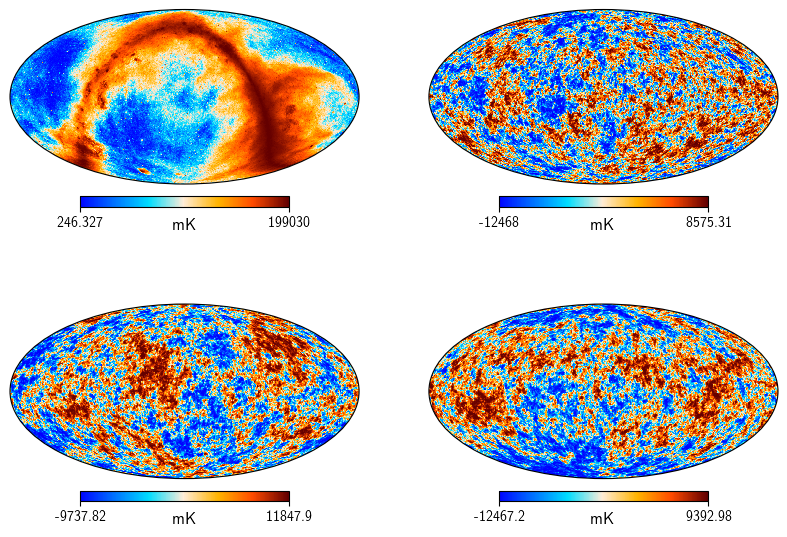

In [27]:
###############################
# Wrong way!! Using directly from ANAFAST!! there is no preservation of alm` phases
###############################
plt.figure(figsize=(8,6))
hpn.projview(hi,norm="hist",cmap="planck", unit='mK', sub=221)
hpn.projview(hii,norm="hist",cmap="planck", unit='mK', sub=222)
hpn.projview(hic,norm="hist",cmap="planck", unit='mK', sub=223)
hpn.projview(hij,norm="hist",cmap="planck", unit='mK', sub=224);

In [13]:
c = 2*['black', 'dimgray', 'dimgrey', 'gray', 'grey', 'darkgray',       'darkgrey', 'silver', 'lightgray', 'lightgrey', 'gainsboro',
       'whitesmoke', 'white', 'snow', 'rosybrown', 'lightcoral',       'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red',
       'mistyrose', 'salmon', 'tomato', 'darksalmon', 'coral',       'orangered', 'lightsalmon', 'sienna', 'seashell', 'chocolate',
       'saddlebrown', 'sandybrown', 'peachpuff', 'peru', 'linen',       'bisque', 'darkorange', 'burlywood', 'antiquewhite', 'tan',
       'navajowhite', 'blanchedalmond', 'papayawhip', 'moccasin',       'orange', 'wheat', 'oldlace', 'floralwhite', 'darkgoldenrod',
       'goldenrod', 'cornsilk', 'gold', 'lemonchiffon', 'khaki',       'palegoldenrod', 'darkkhaki', 'ivory', 'beige', 'lightyellow',
       'lightgoldenrodyellow', 'olive', 'yellow', 'olivedrab',       'yellowgreen', 'darkolivegreen', 'greenyellow', 'chartreuse',
       'lawngreen', 'honeydew', 'darkseagreen', 'palegreen', 'lightgreen',       'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime',
       'seagreen', 'mediumseagreen', 'springgreen', 'mintcream',       'mediumspringgreen', 'mediumaquamarine', 'aquamarine', 'turquoise',
       'lights2727eagreen', 'mediumturquoise', 'azure', 'lightcyan',       'paleturquoise', 'darkslategray', 'darkslategrey', 'teal',
       'darkcyan', 'aqua', 'cyan', 'darkturquoise', 'cadetblue',       'powderblue', 'lightblue', 'deepskyblue', 'skyblue',
       'lightskyblue', 'steelblue', 'aliceblue', 'dodgerblue',       'lightslategray', 'lightslategrey', 'slategray', 'slategrey',
       'lightsteelblue', 'cornflowerblue', 'royalblue', 'ghostwhite',       'lavender', 'midnightblue', 'navy', 'darkblue', 'mediumblue',
       'blue', 'slateblue', 'darkslateblue', 'mediumslateblue',       'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo',
       'darkorchid', 'darkviolet', 'mediumorchid', 'thistle', 'plum',       'violet', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid',
       'mediumvioletred', 'deeppink', 'hotpink','observed map' 'lavenderblush',       'palevioletred', 'crimson', 'pink', 'lightpink']
markers_ = 2*[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","x","X","D","d",0,1,2,3,4,5,6,7,8,9,10,11]

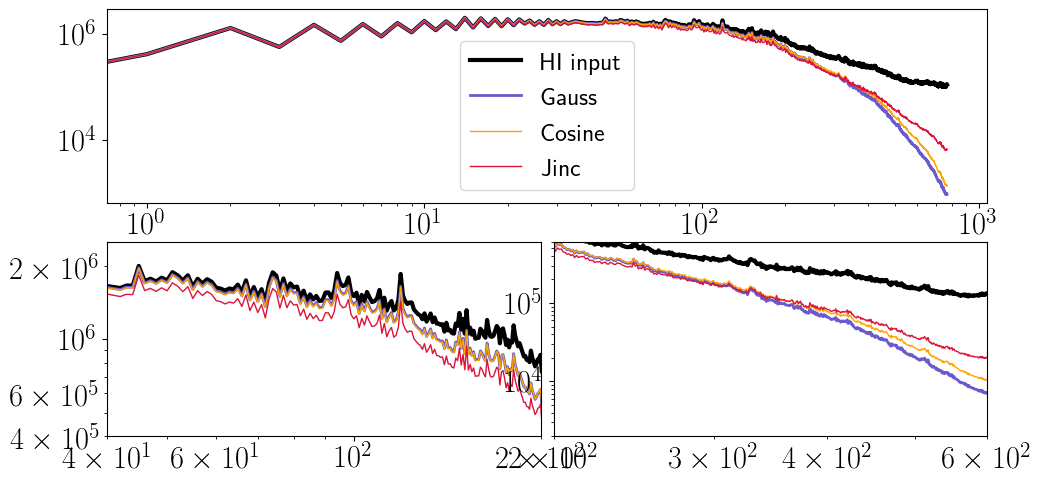

In [29]:
grid = plt.GridSpec(2,2,top=1.,right=1.5,wspace=0.03)
ax = plt.subplot(grid[0,:])
fact = l*(l+1)/(2*np.pi)
plt.plot(l,fact*cl,          label="HI input" , linewidth=3, color=c[0])
plt.plot(l,fact*cl*(blg**2), label="Gauss"    , linewidth=2, color=c[122])
plt.plot(l,fact*cl*(blc**2), label="Cosine"   , linewidth=1, color=c[194])
plt.plot(l,fact*cl*(blj**2), label="Jinc"     , linewidth=1, color=c[145])
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(fontsize="small")

ax = plt.subplot(grid[1,0])
plt.plot(l,fact*cl,          label="HI input" , linewidth=3, color=c[0])
plt.plot(l,fact*cl*(blg**2), label="Gauss"    , linewidth=2, color=c[122])
plt.plot(l,fact*cl*(blc**2), label="Cosine"   , linewidth=1, color=c[194])
plt.plot(l,fact*cl*(blj**2), label="Jinc"     , linewidth=1, color=c[145])
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(40, 200)
plt.ylim(4e5, 2.5e6)

ax = plt.subplot(grid[1,1])
plt.plot(l,fact*cl,          label="HI input" , linewidth=3, color=c[0])
plt.plot(l,fact*cl*(blg**2), label="Gauss"    , linewidth=2, color=c[122])
plt.plot(l,fact*cl*(blc**2), label="Cosine"   , linewidth=1, color=c[194])
plt.plot(l,fact*cl*(blj**2), label="Jinc"     , linewidth=1, color=c[145])
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(200, 600)
plt.ylim(2e3, 6e5);

In [31]:
alm_hi = hp.map2alm(hi,lmax=lmax)
fwhm   = model.fwhm_modelling(nu=inu, type_= output_info["type_fwhm"], D=output_info["main_dish_diameter"], in_degree=True)
blg    = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

In [32]:
alm_hi_mod = hp.almxfl(alm_hi, blg)
hi_mod = hp.alm2map(alm_hi_mod,nside=256,lmax=lmax, pol=False)

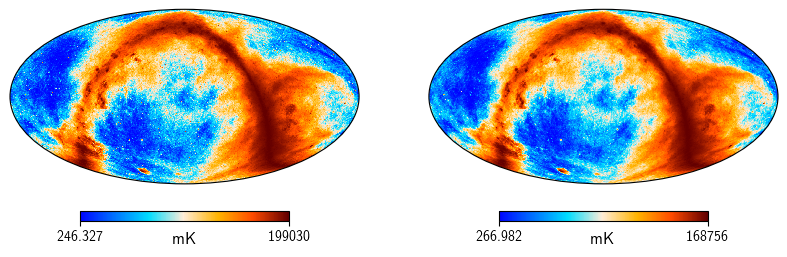

In [33]:
plt.figure(figsize=(8,6))
hpn.projview(hi,     norm="hist", cmap="planck", unit='mK', sub=121)
hpn.projview(hi_mod, norm="hist", cmap="planck", unit='mK', sub=122);

## ---A---

In [14]:
output_info = {"pathdir_HI" :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI512',
               "pathdir_N"  :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/WN512',
               "realization": 2,
               "pathdir_FG" :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/FG512',
               "nameFG"     :'FG_I_512_980mhz1260mhz_30bins_full_L0.fits',
               "pathdir_PL" :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/PL512',
               "namePL"     :'PL_QU_512_980mhz1260mhz_30bins_full_2eQ_1eU_L0.fits',
               "apply_mask" : True,
               "pathdir_M"  :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/M256',
               "nameM"      :'mask_256_5degC2apod_20fgcut.fits',
               "apply_beam" : True, 
               "type_beam"  :'gaussian',
               "type_fwhm"  :'ripple',
               "if_fwhm_cte": None,
               "main_dish_diameter": 40,
               "lmax"       : None,
               "theta_range": None,
               'new_nside'  : 256,
               'output_dir' :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset_processed',
               'first_name' :'BINGO',
               'add_name' : None
              }

In [15]:
filenames = hdata.get_allfilenames(dirpath_=output_info['pathdir_HI'])
with fits.open(os.path.join(output_info['pathdir_HI'],filenames[0])) as h:
        output_info['nu'] = dcopy(h[0].data)
#if there is no new nside just keep the same getting from the first HI name
if not type(output_info['new_nside'])==np.int:
    output_info['new_nside'] = int(filenames[0].split("_")[2])
#theta
if (type(output_info['lmax']) == np.float or type(output_info['lmax']) == np.int):
    output_info['lmax'] = np.asarray(output_info['lmax'])
else:
    output_info['lmax']  = 3*output_info['new_nside']
#theta
if (type(output_info['theta_range'])==np.ndarray or type(output_info['theta_range'])==range or type(output_info['theta_range'])==list):
    output_info['theta_range'] = np.asarray(output_info['theta_range'])
else:
    output_info['theta_range'] = np.arange(0,10,0.01)
#
output_info['l'] = np.arange(output_info['lmax']+1)  

In [16]:
ifilename = np.sort(filenames)[11]
output_info["type_beam"]="cosine"
output_info["main_dish_diameter"]=40
beamed_map   = beam_observed_maps(output_info, ifilename)

In [17]:
output_info["type_beam"]="gaussian"
output_info["main_dish_diameter"]=40
beamed_map13 = beam_observed_maps(output_info, ifilename)

In [18]:
beamed_map['unconvolved map']

array([[1423.31325683, 1346.9746441 , 1350.27357472, ..., 1372.052212  ,
        1409.77331891, 1527.82032165],
       [1384.08997112, 1309.21963213, 1312.58582401, ..., 1334.99407638,
        1370.93513199, 1486.44135341],
       [1346.33126616, 1272.78427055, 1276.30776396, ..., 1299.29271091,
        1333.61194152, 1446.36068932],
       ...,
       [ 725.82091512,  677.84065613,  682.36556236, ...,  709.74821296,
         719.76684085,  786.86036921],
       [ 709.880357  ,  662.73808566,  667.14802684, ...,  694.5183275 ,
         704.02764068,  770.12501303],
       [ 694.45037825,  647.99443123,  652.49667265, ...,  679.75218453,
         688.74747175,  753.41824986]])

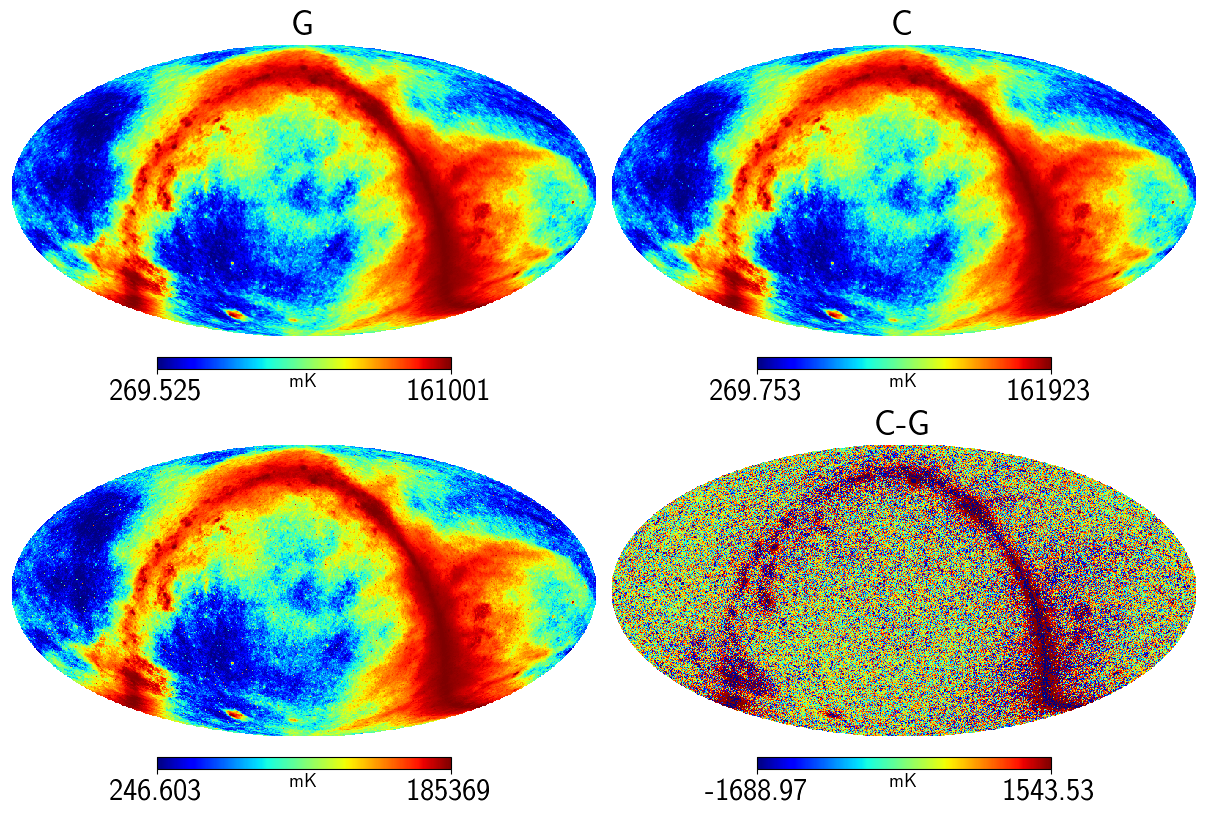

In [19]:
plt.figure(figsize=(12,8))
cmap='jet'
hp.mollview(beamed_map['unconvolved map'][-1], norm="hist", cmap=cmap, unit='mK', sub=223, title=None)
hp.mollview(beamed_map[  'convolved map'][-1], norm="hist", cmap=cmap, unit='mK', sub=222, title='C')
hp.mollview(beamed_map13['convolved map'][-1], norm="hist", cmap=cmap, unit='mK', sub=221, title='G')
hp.mollview(beamed_map[  'convolved map'][-1]-beamed_map13['convolved map'][-1], norm="hist", cmap=cmap, unit='mK', sub=224, title='C-G');

In [46]:
id   = ifilename.split("_L")[1].split(".fits")[0]
part = filenamesN_template.split("_L")[1]
Nfilename = filenamesN_template.replace(part, id+".fits")

In [48]:
if type(output_info['pathdir_N'])!=type(None) and type(output_info['pathdir_N'])==np.str:
    Nmap = hdata.getmap(dirpath_ =output_info['pathdir_N'], 
                        filename_=Nfilename, 
                        healpix_readingformat=False, hdu=1)
    Nmap = hp.ud_grade(Nmap[i], output_info['new_nside'])
    imap_mod+=Nmap
if output_info['apply_mask']:
    mask = hdata.getmap(dirpath_ = output_info['pathdir_M'], 
                        filename_= output_info['nameM'], 
                        healpix_readingformat=False, hdu=1)    

NameError: name 'imap_mod' is not defined

In [49]:
if output_info['apply_mask']:
    mask = hdata.getmap(dirpath_ = output_info['pathdir_M'], 
                        filename_= output_info['nameM'], 
                        healpix_readingformat=False, hdu=1) 

In [50]:
plt.figure(figsize=(20,4))
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "jet"

hp.cartview(imap_mod,     norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=311, )

hp.cartview(imap_mod*mask, norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=312)
hp.cartview(imap*mask, norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=313)#cbar=None)

NameError: name 'imap_mod' is not defined

<Figure size 2000x400 with 0 Axes>

ValueError: Wrong pixel number (it is not 12*nside**2)

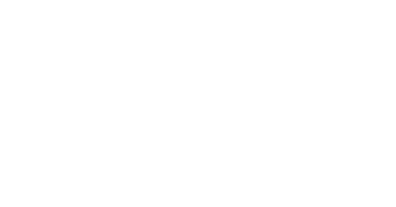

In [51]:
plt.figure(figsize=(12,6))
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 1
Ra_min  = 0 - 33.333333333333336/2
Ra_max  = 0 + 33.333333333333336/2
CMAP    = "jet"
NORM='hist'

hp.cartview(imap , unit=None,  latra=[Dec_min,Dec_max],  lonra=[Ra_min,Ra_max], 
            cmap=CMAP, title=None , sub=311, norm=NORM)
hp.cartview(imap*mask ,  latra=[Dec_min,Dec_max],  lonra=[Ra_min,Ra_max], unit="mK",
            cmap=CMAP, title=None , sub=312, norm=NORM)
hp.cartview(imap_mod*mask, 
            latra=[Dec_min,Dec_max], 
            lonra=[Ra_min,Ra_max],             
            cmap=CMAP, title=None,unit="mK", sub=313, norm=NORM)

In [ ]:
plt.figure(figsize=(12,6))
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 1
Ra_min  = 0 - 33.333333333333336/2
Ra_max  = 0 + 33.333333333333336/2
Ra_min += 100
Ra_max += 85
CMAP    = "jet"
NORM='hist'

hp.cartview(imap , unit=None,  latra=[Dec_min,Dec_max],  lonra=[Ra_min,Ra_max], 
            cmap=CMAP, title=None , sub=311, norm=NORM)
hp.cartview(imap*mask ,  latra=[Dec_min,Dec_max],  lonra=[Ra_min,Ra_max], unit="mK",
            cmap=CMAP, title=None , sub=312, norm=NORM)
hp.cartview(imap_mod*mask, 
            latra=[Dec_min,Dec_max], 
            lonra=[Ra_min,Ra_max],             
            cmap=CMAP, title=None,unit="mK", sub=313, norm=NORM)

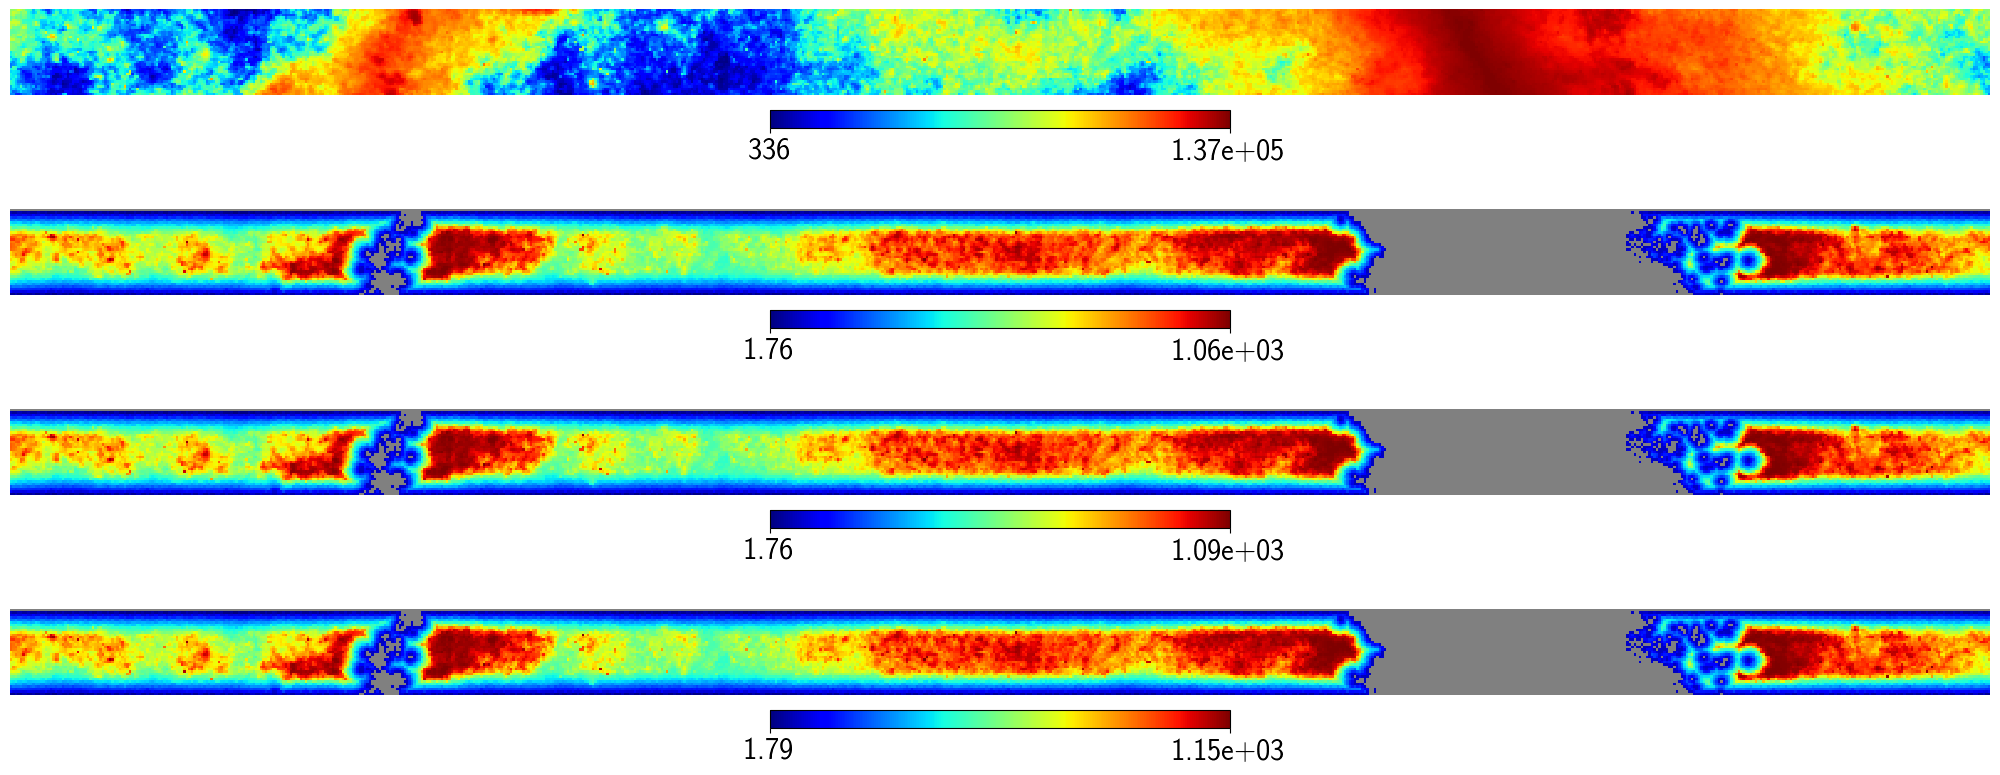

In [54]:
plt.figure(figsize=(20,8))
dec_min = -25.282 #from hitmap
dec_max =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "jet"

######
#output_info['nameFG'] = None
#output_info['namePL'] = None
#output_info["pathdir_N"] = None 
output_info["type_beam"]="gaussian"
output_info["main_dish_diameter"]=40
omap = sky_observation(output_info, ifilename)
ind  = np.where(omap['mask']<=0)[0]
jmap = dcopy(omap['observed map'][i])
jmap[ind]=hp.UNSEEN
hp.cartview(jmap                    , norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=412, )
hp.cartview(omap['convolved map'][i], norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=411, )

output_info["type_beam"]="cosine"
output_info["main_dish_diameter"]=40
omap = sky_observation(output_info, ifilename)
ind  = np.where(omap['mask']<=0)[0]
jmap = dcopy(omap['observed map'][i])
jmap[ind]=hp.UNSEEN
hp.cartview(jmap, norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=413, )

output_info["type_beam"]="jinc"
output_info["main_dish_diameter"]=40
omap = sky_observation(output_info, ifilename)
ind = np.where(omap['mask']<=0)[0]
jmap = dcopy(omap['observed map'][i])
jmap[ind]=hp.UNSEEN
hp.cartview(jmap , norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=414, );

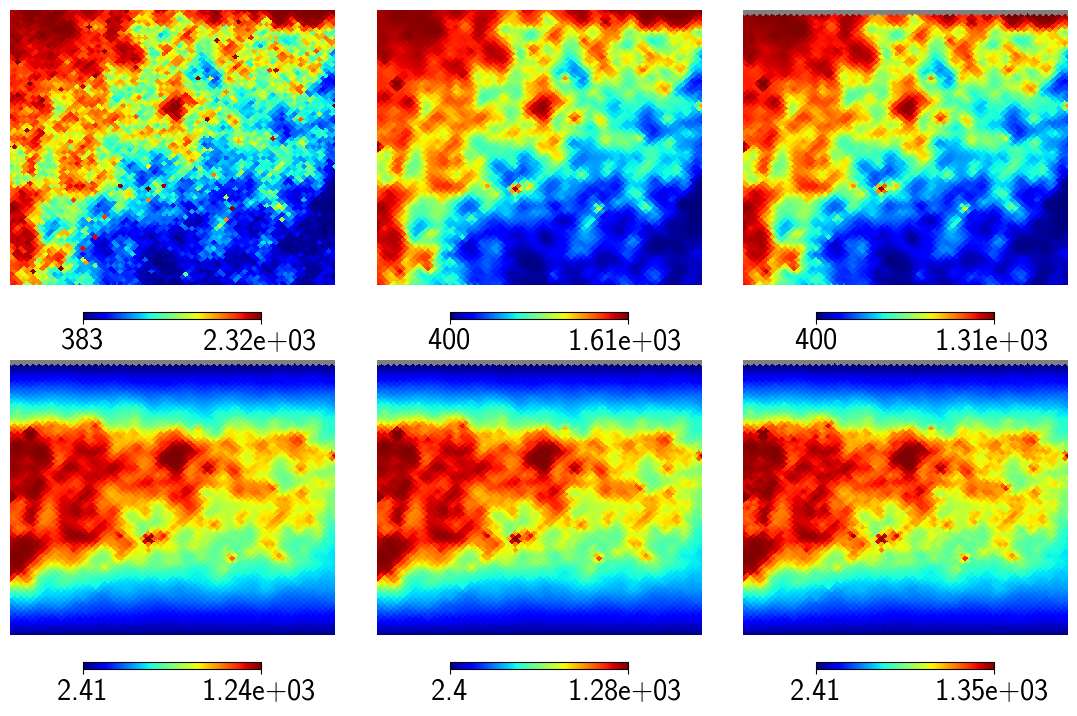

In [21]:
plt.figure(figsize=(11,7))
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "jet"
Ra_min  = 0 - 33.333333333333336/2
Ra_max  = 0 + 33.333333333333336/2
Ra_min += 100
Ra_max += 85
######
D   = [40,40,40]
tb  = ["gaussian", "cosine", "jinc"]
pos = [234,235,236]
i=-1
j=0
output_info["type_beam"]=tb[j]
output_info["main_dish_diameter"]=D[j]
omap = sky_observation(output_info, ifilename)
for j in range(3):
    output_info["type_beam"]=tb[j]
    output_info["main_dish_diameter"]=D[j]
    omap = sky_observation(output_info, ifilename)  
    ind  = np.where(omap['mask']<=0)[0]
    jmap = dcopy(omap['observed map'][i])
    jmap[ind]=hp.UNSEEN  
    hp.cartview(jmap,  norm="hist" , unit=None,  latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap=CMAP, title=None,  sub=pos[j] )
j=0
output_info["type_beam"]=tb[j]
output_info["main_dish_diameter"]=D[j]
omap = sky_observation(output_info, ifilename)
hp.cartview(omap['unconvolved map'][i]           ,norm="hist", unit=None,  latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap=CMAP, title=None,  sub=231 )    
hp.cartview(omap['convolved map'][i]             ,norm="hist", unit=None,  latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap=CMAP, title=None,  sub=232 )

jmap = dcopy(omap['convolved map'][i])
jmap[ind]=hp.UNSEEN  
hp.cartview(jmap, norm="hist", unit=None,  latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap=CMAP, title=None,  sub=233 )  

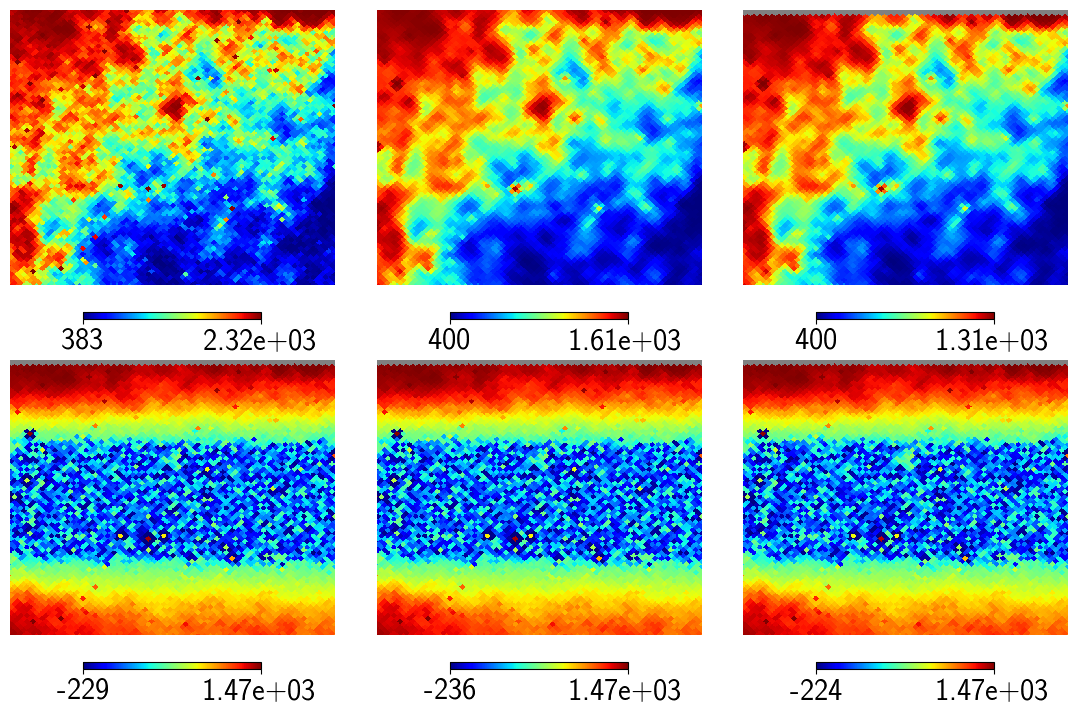

In [24]:
plt.figure(figsize=(11,7))
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "jet"
Ra_min  = 0 - 33.333333333333336/2
Ra_max  = 0 + 33.333333333333336/2
Ra_min += 100
Ra_max += 85
######
D   = [40,40,40]
tb  = ["gaussian", "cosine", "jinc"]
pos = [234,235,236]
i=-1
j=0
output_info["type_beam"]=tb[j]
output_info["main_dish_diameter"]=D[j]
omap = sky_observation(output_info, ifilename)
for j in range(3):
    output_info["type_beam"]=tb[j]
    output_info["main_dish_diameter"]=D[j]
    omap = sky_observation(output_info, ifilename)  
    ind  = np.where(omap['mask']<=0)[0]
    jmap = dcopy(omap['unconvolved map'][i] - omap['observed map'][i])
    jmap[ind]=hp.UNSEEN  
    hp.cartview(jmap,  norm="hist" , unit=None,  latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap=CMAP, title=None,  sub=pos[j] )
j=0
output_info["type_beam"]=tb[j]
output_info["main_dish_diameter"]=D[j]
omap = sky_observation(output_info, ifilename)
hp.cartview(omap['unconvolved map'][i]           ,norm="hist", unit=None,  latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap=CMAP, title=None,  sub=231 )    
hp.cartview(omap['convolved map'][i]             ,norm="hist", unit=None,  latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap=CMAP, title=None,  sub=232 )

jmap = dcopy(omap['convolved map'][i])
jmap[ind]=hp.UNSEEN  
hp.cartview(jmap, norm="hist", unit=None,  latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap=CMAP, title=None,  sub=233 )  

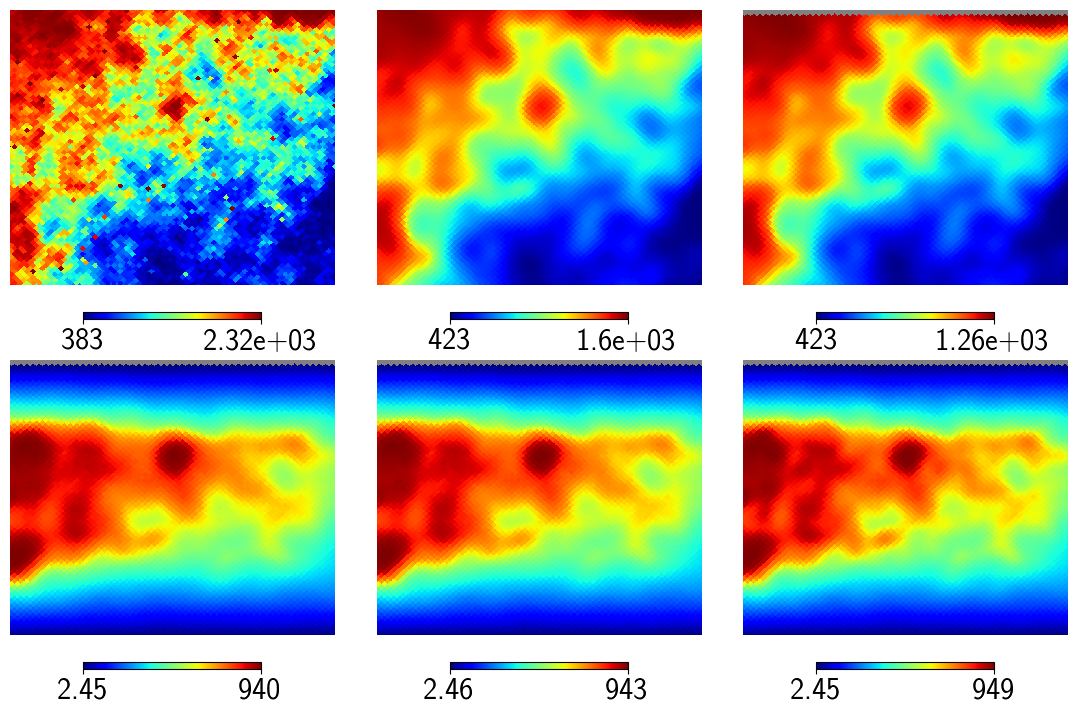

In [22]:
plt.figure(figsize=(11,7))
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "jet"
Ra_min  = 0 - 33.333333333333336/2
Ra_max  = 0 + 33.333333333333336/2
Ra_min += 100
Ra_max += 85
######
D   = [13,13,13]
tb  = ["gaussian", "cosine", "jinc"]
pos = [234,235,236]
i=-1
j=0
output_info["type_beam"]=tb[j]
output_info["main_dish_diameter"]=D[j]
omap = sky_observation(output_info, ifilename)
for j in range(3):
    output_info["type_beam"]=tb[j]
    output_info["main_dish_diameter"]=D[j]
    omap = sky_observation(output_info, ifilename)  
    ind  = np.where(omap['mask']<=0)[0]
    jmap = dcopy(omap['observed map'][i])
    jmap[ind]=hp.UNSEEN  
    hp.cartview(jmap,  norm="hist" , unit=None,  latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap=CMAP, title=None,  sub=pos[j] )
j=0
output_info["type_beam"]=tb[j]
output_info["main_dish_diameter"]=D[j]
omap = sky_observation(output_info, ifilename)
hp.cartview(omap['unconvolved map'][i]           ,norm="hist", unit=None,  latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap=CMAP, title=None,  sub=231 )    
hp.cartview(omap['convolved map'][i]             ,norm="hist", unit=None,  latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap=CMAP, title=None,  sub=232 )

jmap = dcopy(omap['convolved map'][i])
jmap[ind]=hp.UNSEEN  
hp.cartview(jmap, norm="hist", unit=None,  latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap=CMAP, title=None,  sub=233 )  

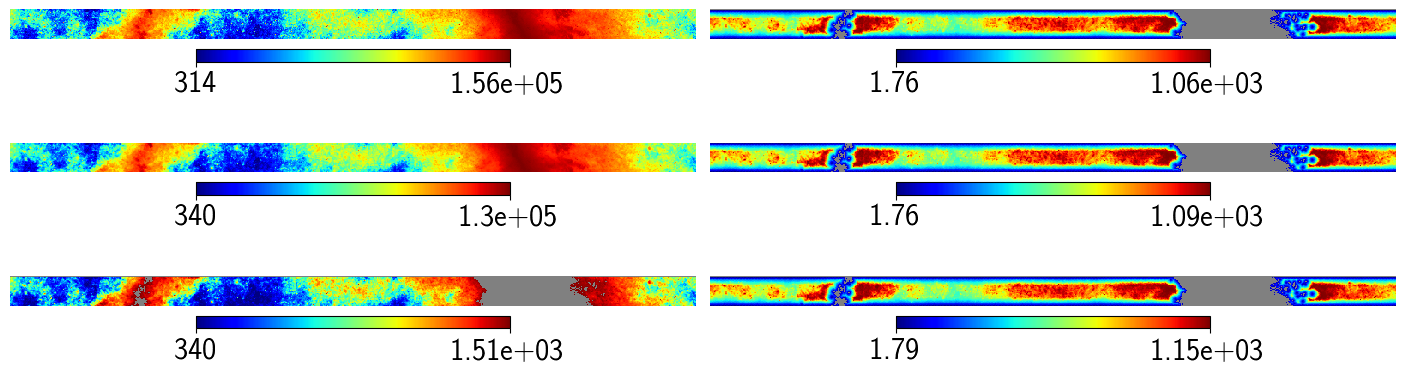

In [57]:
plt.figure(figsize=(14,4))
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "jet"
Ra_min  = 0 - 33.333333333333336/2
Ra_max  = 0 + 33.333333333333336/2
Ra_min += 100
Ra_max += 85
######
D   = [40,40,40]
tb  = ["gaussian", "cosine", "jinc"]
pos = [322,324,326]
i=-1
j=0
output_info["type_beam"]=tb[j]
output_info["main_dish_diameter"]=D[j]
omap = sky_observation(output_info, ifilename)
for j in range(3):
    output_info["type_beam"]=tb[j]
    output_info["main_dish_diameter"]=D[j]
    omap = sky_observation(output_info, ifilename)
    ind  = np.where(omap['mask']<=0)[0]
    jmap = dcopy(omap['observed map'][i])
    jmap[ind]=hp.UNSEEN
    hp.cartview(jmap,  norm="hist" , unit=None,  latra=[Dec_min,Dec_max],cmap=CMAP, title=None,  sub=pos[j] )
hp.cartview(omap['unconvolved map'][i]           ,norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=321 )    
hp.cartview(omap['convolved map'][i]             ,norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=323 )
jmap = dcopy(omap['convolved map'][i])
jmap[ind]=hp.UNSEEN  
hp.cartview(jmap,norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=325 )  

In [ ]:
plt.figure(figsize=(14,4))
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "jet"
Ra_min  = 0 - 33.333333333333336/2
Ra_max  = 0 + 33.333333333333336/2
Ra_min += 100
Ra_max += 85
######
D   = [13,13,13]
tb  = ["gaussian", "cosine", "jinc"]
pos = [322,324,326]
i=-1
j=0
output_info["type_beam"]=tb[j]
output_info["main dish diameter"]=D[j]
omap = sky_observation(output_info, ifilename)
for j in range(3):
    output_info["type_beam"]=tb[j]
    output_info["main dish diameter"]=D[j]
    omap = sky_observation(output_info, ifilename)
    ind  = np.where(omap['mask']<=0)[0]
    jmap = dcopy(omap['observed map'][i])
    jmap[ind]=hp.UNSEEN
    hp.cartview(jmap,  norm="hist" , unit=None,  latra=[Dec_min,Dec_max],cmap=CMAP, title=None,  sub=pos[j] )
hp.cartview(omap['unconvolved map'][i]           ,norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=321 )    
hp.cartview(omap['convolved map'][i]             ,norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=323 )
jmap = dcopy(omap['convolved map'][i])
jmap[ind]=hp.UNSEEN  
hp.cartview(jmap,norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=325 )  

In [ ]:
plt.figure(figsize=(20,4))
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "jet"

######
output_info["type_beam"]="gaussian"
output_info["main dish diameter"]=40
gmap = sky_observation(output_info, ifilename)['observed map'][i]

output_info["type_beam"]="cosine"
output_info["main dish diameter"]=40
cmap = sky_observation(output_info, ifilename)['observed map'][i]

output_info["type_beam"]="jinc"
output_info["main dish diameter"]=40
jmap = sky_observation(output_info, ifilename)['observed map'][i]

map1 = gmap-cmap
map2 = gmap-jmap
map3 = cmap-jmap
map1[ind]=hp.UNSEEN
map2[ind]=hp.UNSEEN
map3[ind]=hp.UNSEEN
hp.cartview(map1, norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=311, )
hp.cartview(map2, norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=312, )
hp.cartview(map3, norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=313, )

In [ ]:
plt.figure(figsize=(20,4))
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "jet"

######
output_info["type_beam"]="gaussian"
output_info["main dish diameter"]=13
gmap = sky_observation(output_info, ifilename)['observed map'][i]

output_info["type_beam"]="cosine"
output_info["main dish diameter"]=13
cmap = sky_observation(output_info, ifilename)['observed map'][i]

output_info["type_beam"]="jinc"
output_info["main dish diameter"]=13
jmap = sky_observation(output_info, ifilename)['observed map'][i]

map1 = gmap-cmap
map2 = gmap-jmap
map3 = cmap-jmap
map1[ind]=hp.UNSEEN
map2[ind]=hp.UNSEEN
map3[ind]=hp.UNSEEN
hp.cartview(map1, norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=311, )
hp.cartview(map2, norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=312, )
hp.cartview(map3, norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=313, )

In [ ]:
omap = sky_observation(output_info, ifilename)

## -----------

In [ ]:
output_info = {"pathdir_HI" :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI512',
               "pathdir_N"  :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/WN512',
               "realization": 2,
               "pathdir_FG" :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/FG512',
               "nameFG"     :'FG_I_512_980mhz1260mhz_30bins_full_L0.fits',
               "pathdir_PL" :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/PL512',
               "namePL"     :'PL_QU_512_980mhz1260mhz_30bins_full_2eQ_1eU_L0.fits',
               "apply_mask" : True,
               "pathdir_M"  :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/M256',
               "nameM"      :'mask_256_5degC2apod_20fgcut.fits',
               "apply_beam" : True, 
               "type_beam"  :'gaussian',
               "type_fwhm"  :'ripple',
               "if_fwhm_cte": None,
               "main_dish_diameter": 40,
               "lmax"       : None,
               "theta_range": None,
               'new_nside'  : 256,
               'output_dir' :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset_processed',
               'clear_output_dir': False,
               'first_name' :'BINGO',
               'add_info'   : '2eQ_1eU'
              }

In [ ]:
num = 12
len_num = len(str(num))
max_num = 4
iname = "{}{}".format('0'*(max_num-len_num),12)
iname

In [ ]:
iname='0011'
np.array(['_'.join((filenames[0].split('_L')[0],'L' +iname+'.fits')) for iname in ['0012','0001']])

In [ ]:
output_info['realization'] = 2


filenames = np.sort(hdata.get_allfilenames(dirpath_=output_info['pathdir_HI']))

if (type(output_info['realization'])==list or type(output_info['realization'])==np.ndarray):
    filenames = np.array(['_'.join((filenames[0].split('_L')[0],'L' +iname+'.fits')) for iname in output_info['realization']])  
elif type(output_info['realization'])==str and output_info['realization']!='all':
    filenames = np.array(['_'.join((filenames[0].split('_L')[0],'L' +output_info['realization']+'.fits'))])
elif type(output_info['realization'])==np.int and output_info['realization']<=len(filenames):
    filenames = filenames[:int(output_info['realization'])]
elif output_info['realization']=='all':
    pass #filenames=filenamesWN_None_256_980mhz1260mhz_30bins_partial_L0100.fits
else:
    pass #filenames=filenames
_ids_     = hdata.get_all_realizations_id(filenames_=filenames, new_format=True)

#print("Realizations to be saved: {}".format(filenames))
print("Realizations to be saved: {}\n\n".format(_ids_))
#sys.exit(0)
with fits.open(os.path.join(output_info['pathdir_HI'],filenames[0])) as h:
        output_info['nu'] = dcopy(h[0].data)
#if there is no new nside just keep the same getting from the first HI name
if not type(output_info['new_nside'])==np.int:
    output_info['new_nside'] = int(filenames[0].split("_")[2])
#theta
if (type(output_info['lmax']) == np.float or type(output_info['lmax']) == np.int):
    output_info['lmax'] = np.asarray(output_info['lmax'])
else:
    output_info['lmax']  = 3*output_info['new_nside']
#theta
if (type(output_info['theta_range'])==np.ndarray or type(output_info['theta_range'])==range or type(output_info['theta_range'])==list):
    output_info['theta_range'] = np.asarray(output_info['theta_range'])
else:
    output_info['theta_range'] = np.arange(0,10,0.01)
#
output_info['l']     = np.arange(output_info['lmax']+1)  
###############
for i,ifilename in enumerate(filenames):
    print("Building maps of L{}...".format(_ids_[i]))
    imap = sky_observation(output_info, ifilename) 
    output_info['stokes'] = ifilename.split('_')[1]
    output_info['field' ] = dcopy(output_info['first_name'])
    with fits.open(os.path.join(output_info['pathdir_HI'],ifilename)) as h:
        hdu = dcopy(h)
    output_info['frequency'] = {'min': hdu[1].header['FREQ_MIN'],
                                'max': hdu[1].header['FREQ_MAX'],
                             'nbands': hdu[0].header['NBANDS']}
    if output_info['apply_mask']:
        output_info['coverage'] = 'partial'
    elif len(ifilename.split('partial'))>1:
        output_info['coverage'] = 'partial'
    else:
        output_info['coverage'] = 'full'
    output_info['irealization']  = ifilename.split('_L')[1].split('.fits')[0]
    print("Saving the file...")
    hdr_hdu0 = hdu[0].header
    vec_hdu0 = hdu[0].data
    hdr_hdu1 = creating_observed_FITSheader(output_info)
    vec_hdu1 = imap['observed map']

    new_name = hdata.new_formattingnames(F=output_info['field'], 
                          S=output_info['stokes'],
                          NSIDE_=output_info['new_nside'], 
                          freq_min=str(int(output_info['frequency']['min'])), freq_max=str(int(output_info['frequency']['max'])),freq_unit="mhz",
                          Num_=str(int(output_info['frequency']['nbands'])), 
                          C=output_info['coverage'], 
                          Bres=str(int(output_info['fwhm']*60)), Bmodel=output_info['type_fwhm']+get_beam_model_inv(output_info['type_beam']),
                          A=output_info['add_info'], R=output_info['irealization'])

    hdu0 = fits.PrimaryHDU(header=hdr_hdu0,data=vec_hdu0)
    hdu1 = fits.ImageHDU(  header=hdr_hdu1,data=vec_hdu1, name="MULTIMAPS")
    hdul = fits.HDUList([hdu0,hdu1])
                
    new_name = os.path.join(output_info['output_dir'], new_name)
    print("Saving in {}".format(new_name))
    hdul.writeto(new_name,overwrite=True)                
    print("Saved.\n")

In [ ]:
output_info['output_dir']

In [ ]:
iname = ifilename.replace("HI","BINGO").replace("full","partial").replace(str(512), str(output_info['new_nside']))
part1,part2 = iname.split("_L")
for iname in ["smoothCO", "rippleG","40arcminJC"]:
    print("_".join((part1, iname , "D40", "2eQ_1eU" ,"L"+part2)))

In [ ]:
'_'.join((output_info['field'],output_info['stokes'], 
          str(int(output_info['frequency']['min']))+'mhz'+ str(int(output_info['frequency']['max']))+'mhz',
          str(output_info['frequency']['nbands'])+'bins',
          output_info['coverage'],
          output_info['add_name'],
          'L'+output_info['irealization'],
          ))+'.fits'

In [ ]:
output_info['frequency']['nbands']

In [ ]:
int(output_info['fwhm']*60)

In [ ]:
output_info['type_fwhm']+get_beam_model_inv(output_info['type_beam'])

In [ ]:
output_info['new_nside']

In [ ]:
hdata.new_formattingnames(F=output_info['field'], 
                          S=output_info['stokes'],
                          NSIDE_=output_info['new_nside'], 
                          freq_min=str(int(output_info['frequency']['min'])), freq_max=str(int(output_info['frequency']['max'])),freq_unit="mhz",
                          Num_=str(int(output_info['frequency']['nbands'])), 
                          C=output_info['coverage'], 
                          Bres=str(int(output_info['fwhm']*60)), Bmodel=output_info['type_fwhm']+get_beam_model_inv(output_info['type_beam']),
                          A=output_info['add_name'], R=output_info['irealization'])

In [ ]:
def save_FITS_newformat_observed(output_info=None):    
    if output_info['output_dir']==None:
        file_verification(os.getcwd(),"","outputs")
        pathout = os.path.join(os.getcwd(),"outputs")
    else:
        pathout = output_info['output_dir']
    if output_info['clear_output_dir']:
        cmd = "rm -rf {}/*".format(pathout)
        os.popen(cmd).readlines()        
    
    filenames = np.sort(hdata.get_allfilenames(dirpath_=output_info['pathdir_HI']))
    
    if (type(output_info['realization'])==list or type(output_info['realization'])==np.ndarray):
        filenames = np.array(['_'.join((filenames[0].split('_L')[0],'L' +iname+'.fits')) for iname in output_info['realization']])  
    elif type(output_info['realization'])==str and output_info['realization']!='all':
        filenames = np.array(['_'.join((filenames[0].split('_L')[0],'L' +output_info['realization']+'.fits'))])
    elif type(output_info['realization'])==np.int and output_info['realization']<=len(filenames):
        filenames = filenames[:int(output_info['realization'])]
    elif output_info['realization']=='all':
        pass #filenames=filenames
    else:
        pass #filenames=filenames
    _ids_     = hdata.get_all_realizations_id(filenames_=filenames, new_format=True)
    
    #print("Realizations to be saved: {}".format(filenames))
    print("Realizations to be saved: {}\n\n".format(_ids_))
    #sys.exit(0)
    with fits.open(os.path.join(output_info['pathdir_HI'],filenames[0])) as h:
            output_info['nu'] = dcopy(h[0].data)
    #if there is no new nside just keep the same getting from the first HI name
    if not type(output_info['new_nside'])==np.int:
        output_info['new_nside'] = int(filenames[0].split("_")[2])
    #theta
    if (type(output_info['lmax']) == np.float or type(output_info['lmax']) == np.int):
        output_info['lmax'] = np.asarray(output_info['lmax'])
    else:
        output_info['lmax']  = 3*output_info['new_nside']
    #theta
    if (type(output_info['theta_range'])==np.ndarray or type(output_info['theta_range'])==range or type(output_info['theta_range'])==list):
        output_info['theta_range'] = np.asarray(output_info['theta_range'])
    else:
        output_info['theta_range'] = np.arange(0,10,0.01)
    #
    output_info['l']     = np.arange(output_info['lmax']+1)  
    ###############
    for i,ifilename in enumerate(filenames):
        print("Building maps of L{}...".format(_ids_[i]))
        imap = sky_observation(output_info, ifilename) 
        output_info['stokes'] = ifilename.split('_')[1]
        output_info['field' ] = dcopy(output_info['first_name'])
        with fits.open(os.path.join(output_info['pathdir_HI'],ifilename)) as h:
            hdu = dcopy(h)
        output_info['frequency'] = {'min': hdu[1].header['FREQ_MIN'],
                                    'max': hdu[1].header['FREQ_MAX'],
                                 'nbands': hdu[0].header['NBANDS']}
        if output_info['apply_mask']:
            output_info['coverage'] = 'partial'
        elif len(ifilename.split('partial'))>1:
            output_info['coverage'] = 'partial'
        else:
            output_info['coverage'] = 'full'
        output_info['irealization']  = ifilename.split('_L')[1].split('.fits')[0]
        print("Saving the file...")
        hdr_hdu0 = hdu[0].header
        vec_hdu0 = hdu[0].data
        hdr_hdu1 = creating_observed_FITSheader(output_info)
        vec_hdu1 = imap['observed map']
    
        new_name = hdata.new_formattingnames(F=output_info['field'], 
                              S=output_info['stokes'],
                              NSIDE_=output_info['new_nside'], 
                              freq_min=str(int(output_info['frequency']['min'])), freq_max=str(int(output_info['frequency']['max'])),freq_unit="mhz",
                              Num_=str(int(output_info['frequency']['nbands'])), 
                              C=output_info['coverage'], 
                              Bres=str(int(output_info['fwhm']*60)), Bmodel=output_info['type_fwhm']+get_beam_model_inv(output_info['type_beam']),
                              A=output_info['add_name'], R=output_info['irealization'])
    
        hdu0 = fits.PrimaryHDU(header=hdr_hdu0,data=vec_hdu0)
        hdu1 = fits.ImageHDU(  header=hdr_hdu1,data=vec_hdu1, name="MULTIMAPS")
        hdul = fits.HDUList([hdu0,hdu1])
                    
        new_name = os.path.join(output_info['output_dir'], new_name)
        print("Saving in {}".format(new_name))
        hdul.writeto(new_name,overwrite=True)                
        print("Saved.\n")
    print('Complete.')

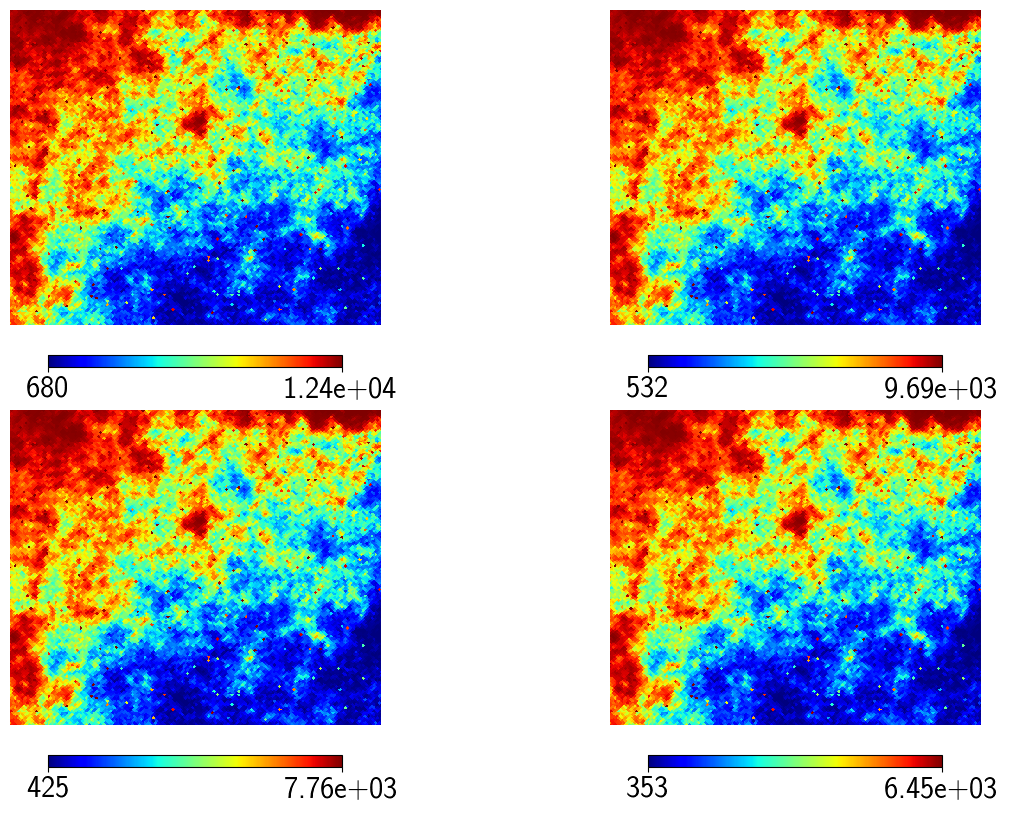

In [71]:
plt.figure(figsize=(12,8))
dec_min = -25.282 #from hitmap
dec_max =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
Ra_min  = 0 - 33.333333333333336/2
Ra_max  = 0 + 33.333333333333336/2
Ra_min += 100
Ra_max += 85
cmap    = "jet"

pos = [221,222,223,224]
ind = np.where(imap[0]<=0)[0]
for i, (jmap, jpos) in enumerate(zip([imap[0],imap[10],imap[20], imap[29]],pos)):
    jmap = dcopy(jmap)
    jmap[ind]=hp.UNSEEN
    hp.cartview(jmap, norm="hist", unit=None,  latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap=cmap, title=None,  sub=jpos )  

In [59]:
dirHI  = '/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI256'
pathHI = 'HI_I_256_980mhz1260mhz_30bins_full_L0100.fits'
dirFG  = '/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/FG256'
pathFG = 'FG_I_256_980mhz1260mhz_30bins_full_L0.fits'
dirWN  = '/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/WN256'
pathWN = 'WN_None_256_980mhz1260mhz_30bins_partial_L0100.fits'
dirM   = '/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/M256'
pathM  = 'mask_256_5degC2apod_20fgcut.fits'

In [60]:
HI = hdata.getmap(dirpath_ = dirHI,filename_= pathHI, 
                  healpix_readingformat=False, hdu=1)
FG = hdata.getmap(dirpath_ = dirFG,filename_= pathFG, 
                  healpix_readingformat=False, hdu=1)
WN = hdata.getmap(dirpath_ = dirWN,filename_= pathWN, 
                  healpix_readingformat=False, hdu=1)
M  = hdata.getmap(dirpath_ = dirM,filename_= pathM, 
                  healpix_readingformat=False, hdu=1)

In [64]:
bin = 10
hi = HI[bin]
fg = FG[bin]
wn = WN[bin]

ind  = np.where(M<=0)[0]
hi_M = dcopy(hi)
hi_M[ind]=hp.UNSEEN
fg_M = dcopy(fg)
fg_M[ind]=hp.UNSEEN
wn_M = dcopy(wn)
wn_M[ind]=hp.UNSEEN

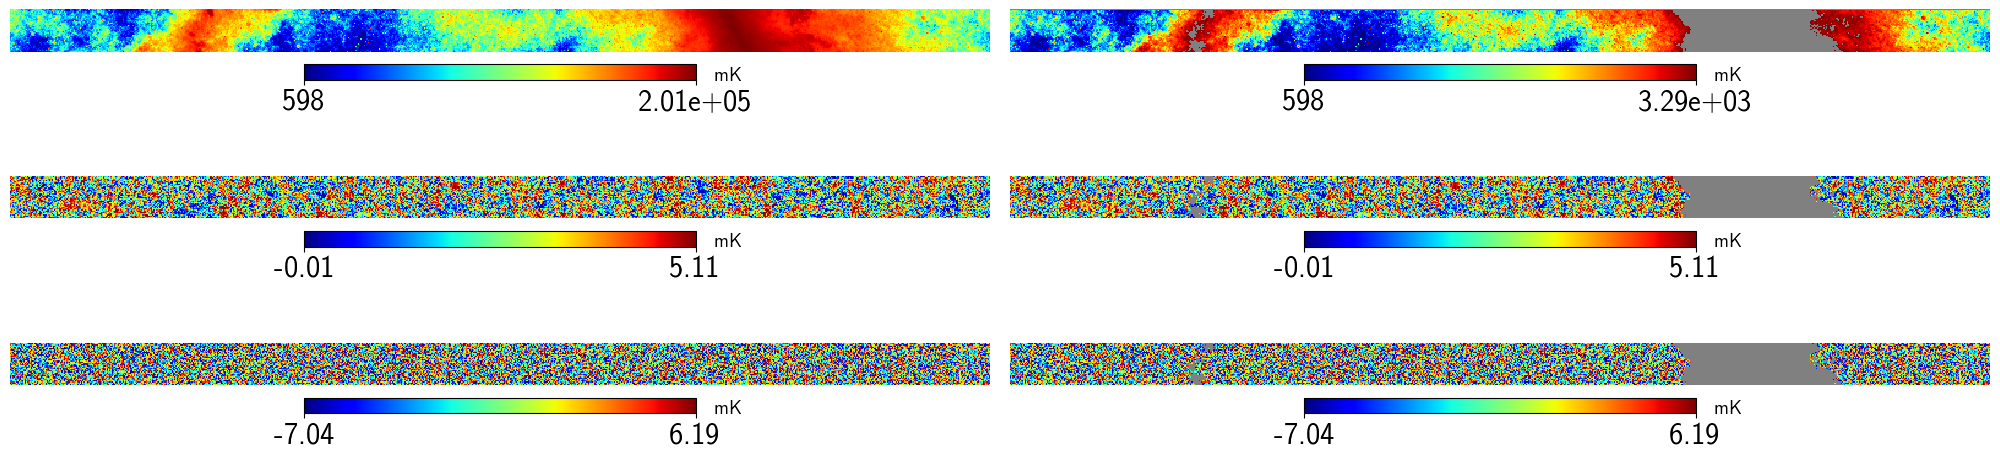

In [69]:
plt.figure(figsize=(20,5))
dec_min = -25.282 #from hitmap
dec_max =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "jet"



#ind  = np.where(omap['mask']<=0)[0]
#jmap = dcopy(omap['observed map'][i])
#jmap[ind]=hp.UNSEEN
hp.cartview(fg, norm="hist", unit='mK',  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=321, )
hp.cartview(hi, norm="hist", unit='mK',  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=323, )
hp.cartview(wn, norm="hist", unit='mK',  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=325, )

hp.cartview(fg_M, norm="hist", unit='mK',  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=322, )
hp.cartview(hi_M, norm="hist", unit='mK',  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=324, )
hp.cartview(wn_M, norm="hist", unit='mK',  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,  sub=326, )
plt.savefig("/home/amarins/{}".format('bingo_region') + ".jpg", dpi=100, bbox_inches='tight');

In [ ]:
clhi   = hp.anafast(hi,pol=False)
clhi_M = hp.anafast(hi*M,pol=False)
clfg   = hp.anafast(fg,pol=False)
clfg_M = hp.anafast(fg*M,pol=False)
clwn   = hp.anafast(wn,pol=False)

In [ ]:
fig       = plt.figure()
grid      = plt.GridSpec(1,1,top=1.,right=2)
l         = np.arange(len(clhi))
fact      = l*(l+1)/(2*np.pi)
#for col,i in enumerate(np.random.randint(nu,size=numplots)):
bins = np.array([bin])
for col,i in enumerate(bins):
    ax = plt.subplot(grid[0,col])
    plt.plot(   l,fact*clhi, color="red"     , label="hi", linewidth =3)
    plt.plot(   l,fact*clhi_M, color="tomato", label="hiM", linewidth =3)

    #plt.plot(   l,fact*clfg  , color="lightgreen" , label="fg", linewidth =2)
    plt.plot(   l,fact*clfg_M, color="forestgreen", label="fgM", linewidth =2)   

    plt.plot(   l,fact*clwn  , color="navy" , label="wn", linewidth =2)     
    
    plt.xscale("log")
    plt.yscale("log")
    ax.tick_params(axis='both', which='major', labelsize = 20)
    plt.ylabel(r"$\ell(\ell+1)$C$_{\ell}/2\pi$ $(\textrm{mK}^2$)", fontsize=20)
    #plt.xlabel(r"$\ell$", fontsize=20)
    plt.legend(fontsize=15)


In [ ]:
path = '/media/BINGODATA1/ComponentSeparation/MAPS/PAPER/MASK'
pathMO1 = 'Mask_Bin.fits'
pathMO2 = 'Mask_tot256.fits'

MO1  = hdata.getmap(dirpath_ = path, filename_= pathMO1, 
                  healpix_readingformat=False, hdu=0)

MO2  = hdata.getmap(dirpath_ = path,filename_= pathMO2, 
                  healpix_readingformat=False, hdu=0)

In [ ]:
import pymaster as nmt

In [ ]:
clfg_MO1 = hp.anafast(fg*MO1,pol=False)
clfg_MO2 = hp.anafast(fg*MO2,pol=False)

clfg_NM   = nmt.NmtField(M, [fg]).get_maps()[0]
clfg_NMO1 = nmt.NmtField(MO1, [fg]).get_maps()[0]
clfg_NMO2 = nmt.NmtField(MO2, [fg]).get_maps()[0]

clfg_NM   = hp.anafast(clfg_NM  , pol=False).get_maps()[0],
clfg_NMO1 = hp.anafast(clfg_NMO1, pol=False)
clfg_NMO2 = hp.anafast(clfg_NMO2, pol=False)


In [ ]:
fig       = plt.figure()
grid      = plt.GridSpec(1,1,top=1.,right=2)
l         = np.arange(len(clhi))
fact      = l*(l+1)/(2*np.pi)
#for col,i in enumerate(np.random.randint(nu,size=numplots)):
bins = np.array([bin])
for col,i in enumerate(bins):
    ax = plt.subplot(grid[0,col])
    #plt.plot(   l,fact*clfg,     color="black",      label="fg",    linewidth =2) 
    plt.plot(   l,fact*clfg_M,   color="green",      label="new MASK",   linewidth =2) 
    plt.plot(   l,fact*clfg_MO1, color="navy",       label="binary last MASK", linewidth =1) 
    plt.plot(   l,fact*clfg_MO2, color="darkorange", label="smooth last MASK", linewidth =1)   

    plt.plot(   l,fact*clfg_NM,  color="green",      label="new MASK",   linewidth =4       , linestyle='dashed' ) 
    plt.plot(   l,fact*clfg_NMO1, color="navy",       label="binary last MASK", linewidth =4, linestyle='dashed' ) 
    plt.plot(   l,fact*clfg_NMO2, color="darkorange", label="smooth last MASK", linewidth =4, linestyle='dashed' )       
    
    plt.xscale("log")
    plt.yscale("log")
    ax.tick_params(axis='both', which='major', labelsize = 20)
    plt.ylabel(r"$\ell(\ell+1)$C$_{\ell}/2\pi$ $(\textrm{mK}^2$)", fontsize=20)
    #plt.xlabel(r"$\ell$", fontsize=20)
    plt.legend(fontsize=15)

.get_maps()[0],
print('The same!')

In [ ]:
fig       = plt.figure()
grid      = plt.GridSpec(1,1,top=1.,right=2)
l         = np.arange(len(clhi))
fact      = l*(l+1)/(2*np.pi)
#for col,i in enumerate(np.random.randint(nu,size=numplots)):
bins = np.array([bin])
for col,i in enumerate(bins):
    ax = plt.subplot(grid[0,col])
    plt.plot(   l,fact*clfg,     color="black",      label="fg",    linewidth =2) 
    plt.plot(   l,fact*clfg_M,   color="green",      label="new MASK",   linewidth =2) 
    plt.plot(   l,fact*clfg_MO1, color="navy",       label="binary last MASK", linewidth =1) 
    plt.plot(   l,fact*clfg_MO2, color="darkorange", label="smooth last MASK", linewidth =1)          
    
    plt.xscale("log")
    plt.yscale("log")
    ax.tick_params(axis='both', which='major', labelsize = 20)
    plt.ylabel(r"$\ell(\ell+1)$C$_{\ell}/2\pi$ $(\textrm{mK}^2$)", fontsize=20)
    #plt.xlabel(r"$\ell$", fontsize=20)
    plt.legend(fontsize=15)

In [ ]:
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation/amarins_cs/CHISEL/scripts')
import Extension4BINGO as cs
import statcosmo as statc

In [ ]:
#####################################
#paths
#####################################
pathcls       = "/media/BINGODATA1/ComponentSeparation/amarins_cs/CHISEL/outputs/NEWtest" #ICA_test100
dir_hi        = "21cm"        #Directory name of the cls of the 21cm reconstruction maps
dir_fg        = "foregrounds" #Directory name of the cls of the foregrounds reconstruction maps
dir_prior     = "prior"       #Directory name of the cls of the pcom as (nova) mascararior maps, that can be (21cm + noise) masked
dir_noise     = "noise"       #Directory name of the cls of the noise maps, that can be (WhiteNoise or/and 1/f) masked
dir_pure      = "pure"        #Directory name of the cls of the (only) 21cm maps, masked or not.
dir_projnoise = "projnoise"   #Directory name of the cls of the noise maps, that can be (WhiteNoise or/and 1/f) masked
dir_projpure  = "projpure"    #Directory name of the cls of the (only) 21cm maps, masked or not.
dir_projprior = "projprior"   #

In [ ]:
Cls = cs.loadcls(pathcls,dirs=[dir_hi,dir_fg,dir_prior,dir_noise,dir_pure])  

In [ ]:
fig       = plt.figure()
grid      = plt.GridSpec(1,1,top=1.,right=2)
l         = np.arange(len(clhi))
fact      = l*(l+1)/(2*np.pi)
L0        = list(Cls['21cm'].keys())[0]
#for col,i in enumerate(np.random.randint(nu,size=numplots)):
bins = np.array([bin])
for col,i in enumerate(bins):
    ax = plt.subplot(grid[0,col])
    plt.plot(   l,fact*clfg,     color="black",      label="fg",    linewidth =2) 
    plt.plot(   l,fact*clfg_M,   color="green",      label="new MASK",   linewidth =2) 
    plt.plot(   l,fact*clfg_MO1, color="navy",       label="binary - last MASK", linewidth =1) 
    plt.plot(   l,fact*clfg_MO2, color="darkorange", label="smooth - last MASK", linewidth =1) 
    plt.plot(   l,fact*Cls["foregrounds"][L0][i], color="purple" , label="fgrec", linewidth =3, linestyle='dashed')
    plt.xscale("log")
    plt.yscale("log")
    ax.tick_params(axis='both', which='major', labelsize = 20)
    plt.ylabel(r"$\ell(\ell+1)$C$_{\ell}/2\pi$ $(\textrm{mK}^2$)", fontsize=20)
    #plt.xlabel(r"$\ell$", fontsize=20)
    plt.legend(fontsize=15)

In [ ]:
plt.figure(figsize=(14,5))
dec_min = -25.282 #from hitmap
dec_max =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "viridis"

hp.cartview(M  , norm="hist", unit=None,latra=[Dec_min,Dec_max], cmap=CMAP, title="new",   sub=411, cbar=None)
hp.cartview(MO1, norm="hist", unit=None,latra=[Dec_min,Dec_max], cmap=CMAP, title="binary",sub=412, cbar=None)
hp.cartview(MO2, norm="hist", unit=None,latra=[Dec_min,Dec_max], cmap=CMAP, title="smooth",sub=413,          )
hp.cartview(fg , norm="hist", unit=None,latra=[Dec_min,Dec_max], cmap='jet', title=None  , sub=414, cbar=None)

In [73]:
fmin = 960
fmax = 1260
nch = 30
dnu = (fmax-fmin)/nch
nu = np.arange(960,1260+dnu,dnu)
nu

array([ 960.,  970.,  980.,  990., 1000., 1010., 1020., 1030., 1040.,
       1050., 1060., 1070., 1080., 1090., 1100., 1110., 1120., 1130.,
       1140., 1150., 1160., 1170., 1180., 1190., 1200., 1210., 1220.,
       1230., 1240., 1250., 1260.])

In [78]:
ich = 9
nu[ich:ich+2]

array([1050., 1060.])

In [79]:
ich = 14
nu[ich:ich+2]

array([1100., 1110.])

In [80]:
ich = 19
nu[ich:ich+2]

array([1150., 1160.])